# Documentation for 3A.ipynb

## Introduction
This notebook focuses on building a recommendation system for video games based on their metadata. It includes data loading, preprocessing, exploratory data analysis (EDA), and content-based filtering for recommendations.

## 1. Import Required Libraries
The following libraries are imported for data manipulation, visualization, and machine learning:
- `pandas`: For data manipulation and analysis.
- `numpy`: For numerical operations.
- `scipy.stats`: For statistical tests.
- `matplotlib.pyplot`: For data visualization.
- `seaborn`: For enhanced data visualization.
- `sklearn`: For machine learning algorithms and metrics.

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use('fivethirtyeight')

### 1.1 Data Loading and Initial Exploration
In this section, the dataset is loaded, and basic information, missing values, and sample data are displayed.

In [2]:
# Load the dataset
df = pd.read_csv("3A.tsv", delimiter='\t')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

Dataset Shape: (16928, 17)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16928 entries, 0 to 16927
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            16928 non-null  int64  
 1   Name             16926 non-null  object 
 2   Platform         16928 non-null  object 
 3   Year_of_Release  16928 non-null  int64  
 4   Genre            16926 non-null  object 
 5   Publisher        16873 non-null  object 
 6   NA_Sales         16928 non-null  float64
 7   EU_Sales         16928 non-null  float64
 8   JP_Sales         16928 non-null  float64
 9   Other_Sales      16928 non-null  float64
 10  Global_Sales     16928 non-null  float64
 11  Critic_Score     8260 non-null   float64
 12  Critic_Count     8260 non-null   float64
 13  User_Score       10159 non-null  object 
 14  User_Count       16928 non-null  float64
 15  Developer        10240 non-null  object 
 16  Rating          

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])

# Display sample data
print("\nSample Data:")
df.head()


Missing Values:
Name               2
Genre              2
Publisher         55
Critic_Score    8668
Critic_Count    8668
User_Score      6769
Developer       6688
Rating          6836
dtype: int64

Sample Data:


,index,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,-706.0,NaN,NaN
2,2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,-92.0,NaN,NaN


In [4]:
# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")


Numerical columns: ['index', 'Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Count']
Categorical columns: ['Name', 'Platform', 'Genre', 'Publisher', 'User_Score', 'Developer', 'Rating']


## 2. Preprocess
This section handles missing values and removes unnecessary columns. Duplicates are also removed.
Since my model are going to be based on Name, Year, Platform, Genre, Publisher and Rating, i will focus on those data

In [5]:
df.drop('index', axis= 1, inplace = True)
df = df.dropna(subset=['Name'])

# Check for missing values in important columns
missing_values = df[['Name', 'Year_of_Release', 'Platform', 'Genre', 'Publisher', 'Rating']].isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])


Missing Values:
Publisher      55
Rating       6834
dtype: int64


In [6]:
# Since Only 55 Publisher are missing, i'm going to apply mode imputation
df['Publisher'].fillna(df['Publisher'].mode()[0], inplace=True)

# --- Handling missing rating
# Checking if there are any correlation of Genre and Rating for imputation
# Drop rows with missing values in the 'Rating' column
df_cleaned = df.dropna(subset=['Rating'])

# Create a contingency table for Genre and Rating
contingency_table = pd.crosstab(df_cleaned['Genre'], df_cleaned['Rating'])

# Perform Chi-Square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print("Chi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p}")

Chi-Square Test Results:
Chi-Square Statistic: 5334.359105184876
Degrees of Freedom: 77
P-value: 0.0


C:\Users\Ghazi\AppData\Local\Temp\ipykernel_4128\343199730.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Publisher'].fillna(df['Publisher'].mode()[0], inplace=True)


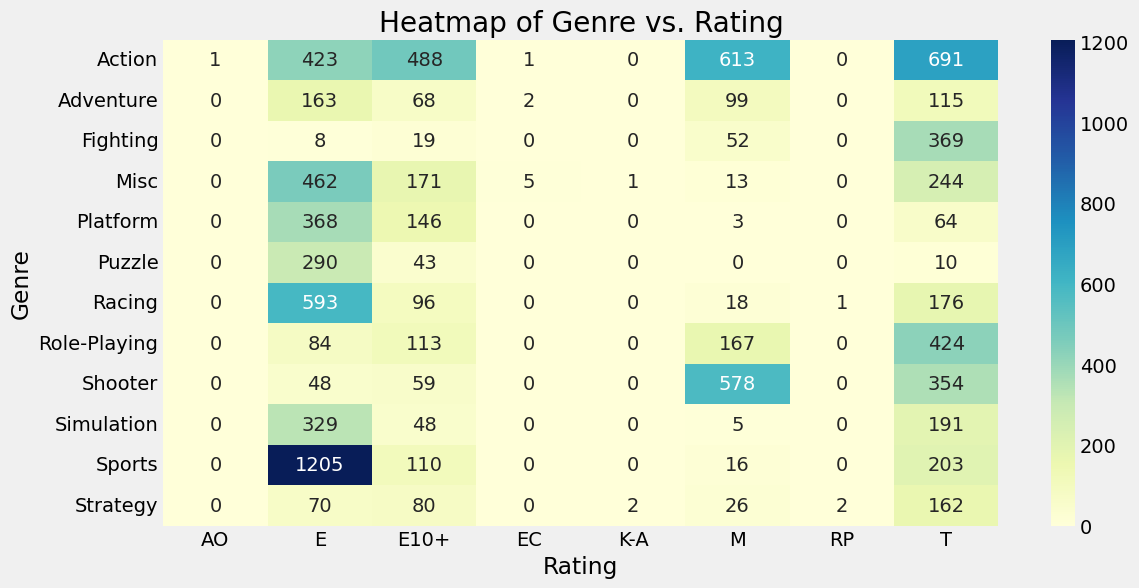

In [7]:
plt.figure(figsize=(12, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Heatmap of Genre vs. Rating")
plt.show()

In [8]:
# Calculate the mode of 'Rating' for each 'Genre'
rating_mode_per_genre = df.groupby('Genre')['Rating'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

# Fill missing 'Rating' values based on the mode of the corresponding 'Genre'
df['Rating'] = df.apply(
    lambda row: rating_mode_per_genre[row['Genre']] if pd.isna(row['Rating']) else row['Rating'], axis=1
)

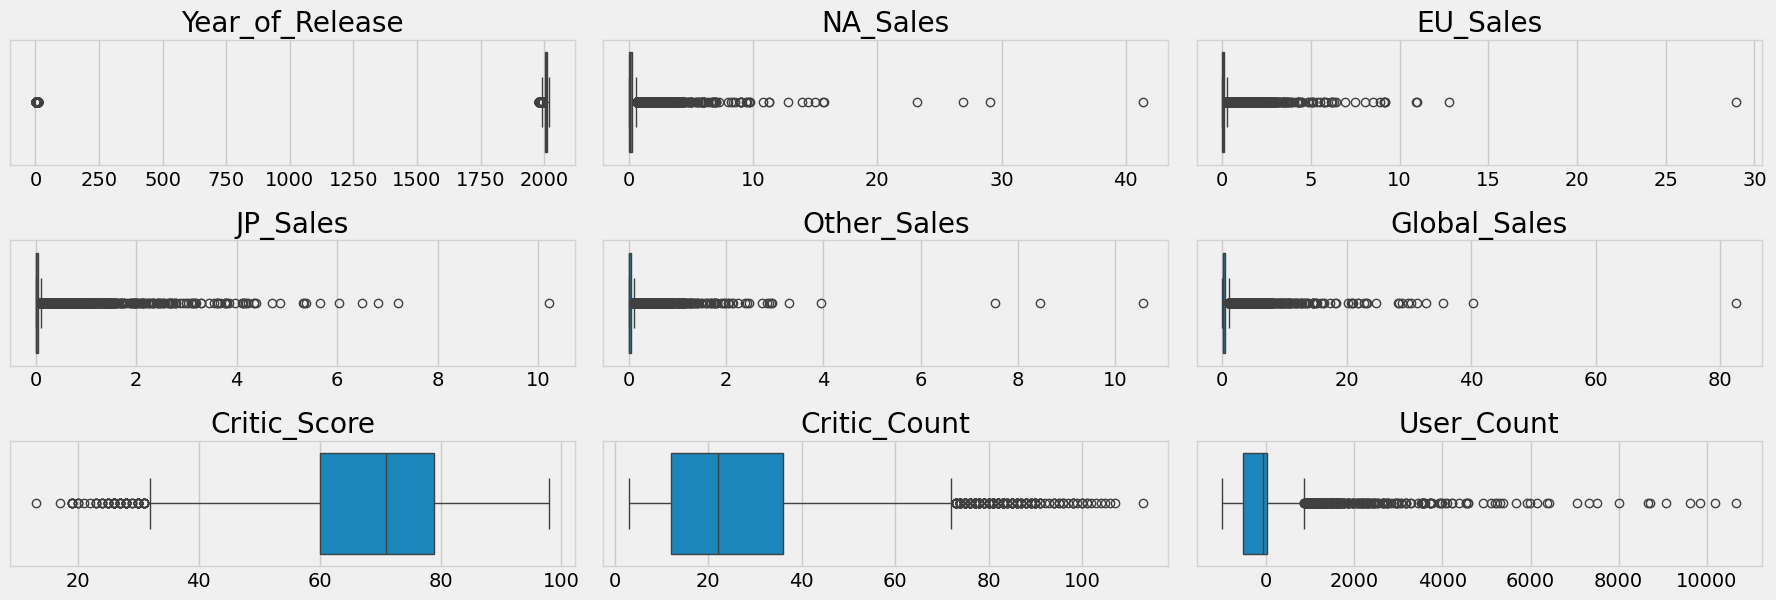

In [9]:
# Visualizing numerical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(18, 10))
n_rows = 5
n_cols = 3
for i, col in enumerate(num_cols, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col], ax=ax)
    plt.title(col)
    plt.xlabel("")
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linewidth(1)
plt.tight_layout() 
plt.show()

In [10]:
# Some data have user_count < 0 which is wierd so i just make them null
df.loc[df['User_Count'] < 0, 'User_Count'] = np.nan

# There are also some game that released prior to year 100?
df.loc[df['Year_of_Release'] < 100, 'Year_of_Release'] += 2000

In [11]:
# Remove duplicates
df = df.drop_duplicates()
print(f"Dataset shape after removing duplicates: {df.shape}")

Dataset shape after removing duplicates: (16721, 16)


In [12]:
# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")


Numerical columns: ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Count']
Categorical columns: ['Name', 'Platform', 'Genre', 'Publisher', 'User_Score', 'Developer', 'Rating']


## 3. EDA
Exploratory Data Analysis is performed to visualize the distribution of the data and relationships between features.

C:\Users\Ghazi\AppData\Local\Temp\ipykernel_4128\3482686983.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_publishers, rotation=80)


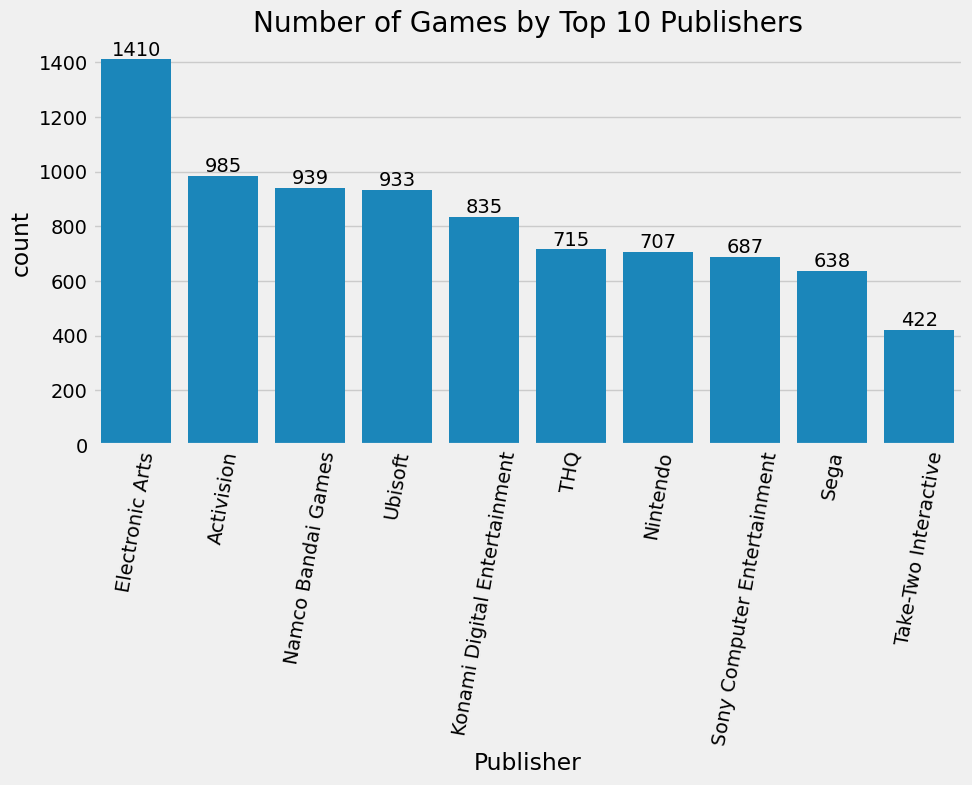

In [13]:
# Create countplot for top publishers
fig, ax = plt.subplots(figsize=(10, 5))
top_publishers = df['Publisher'].value_counts().index[:10]
sns.countplot(x='Publisher', data=df, order=top_publishers, ax=ax)
ax.set_xticklabels(top_publishers, rotation=80)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of Games by Top 10 Publishers')
plt.show()

C:\Users\Ghazi\AppData\Local\Temp\ipykernel_4128\4041630572.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_platforms, rotation=80)


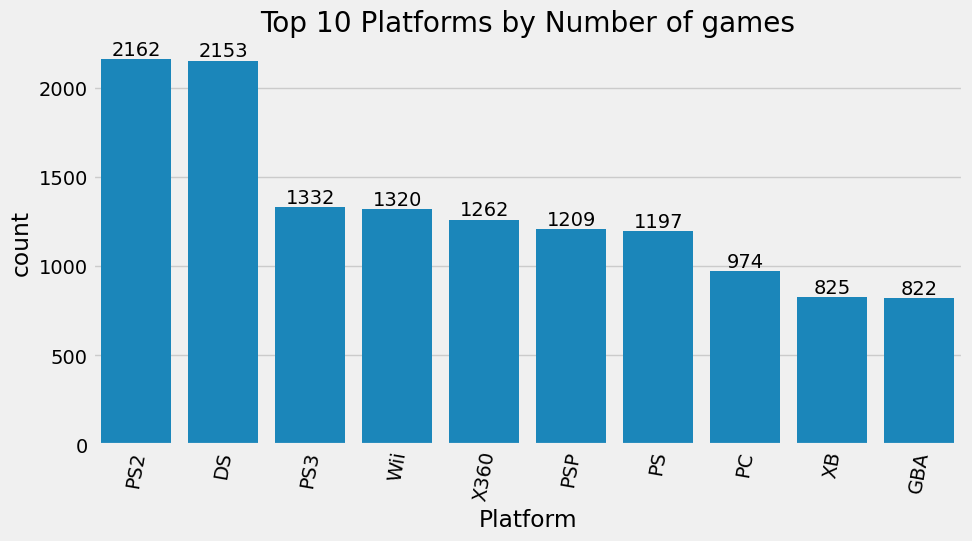

In [14]:
# Create countplot for top platforms
fig, ax = plt.subplots(figsize=(10, 5)) 
top_platforms = df['Platform'].value_counts().index[:10]
sns.countplot(x='Platform', data=df, order=top_platforms, ax=ax)
ax.set_xticklabels(top_platforms, rotation=80)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 Platforms by Number of games')
plt.show()

C:\Users\Ghazi\AppData\Local\Temp\ipykernel_4128\3064348823.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['Genre'].value_counts().index, rotation=80)


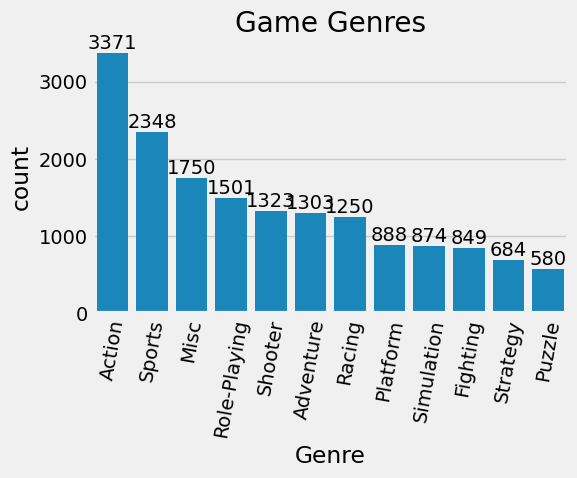

In [15]:
# Create countplot for game genres
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(x='Genre', data=df, order=df['Genre'].value_counts().index)
ax.set_xticklabels(df['Genre'].value_counts().index, rotation=80)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Game Genres')
plt.tight_layout()  # Ensure layout fits
plt.show()

C:\Users\Ghazi\AppData\Local\Temp\ipykernel_4128\1335732643.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['Rating'].value_counts().index, rotation=80)


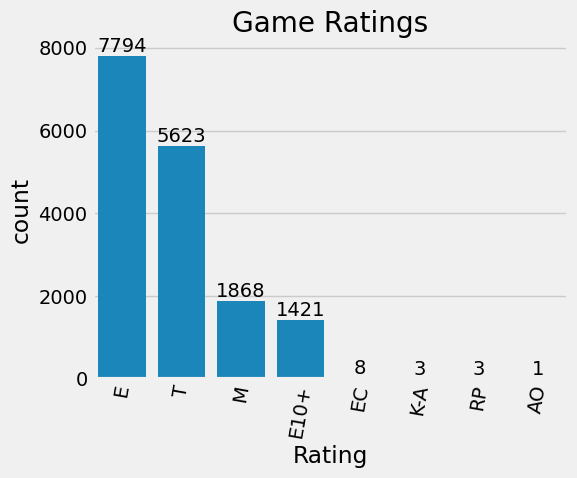

In [16]:
# Create countplot for game ratings
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(x='Rating', data=df, order=df['Rating'].value_counts().index)
ax.set_xticklabels(df['Rating'].value_counts().index, rotation=80)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Game Ratings')
plt.tight_layout()  # Ensure layout fits
plt.show()

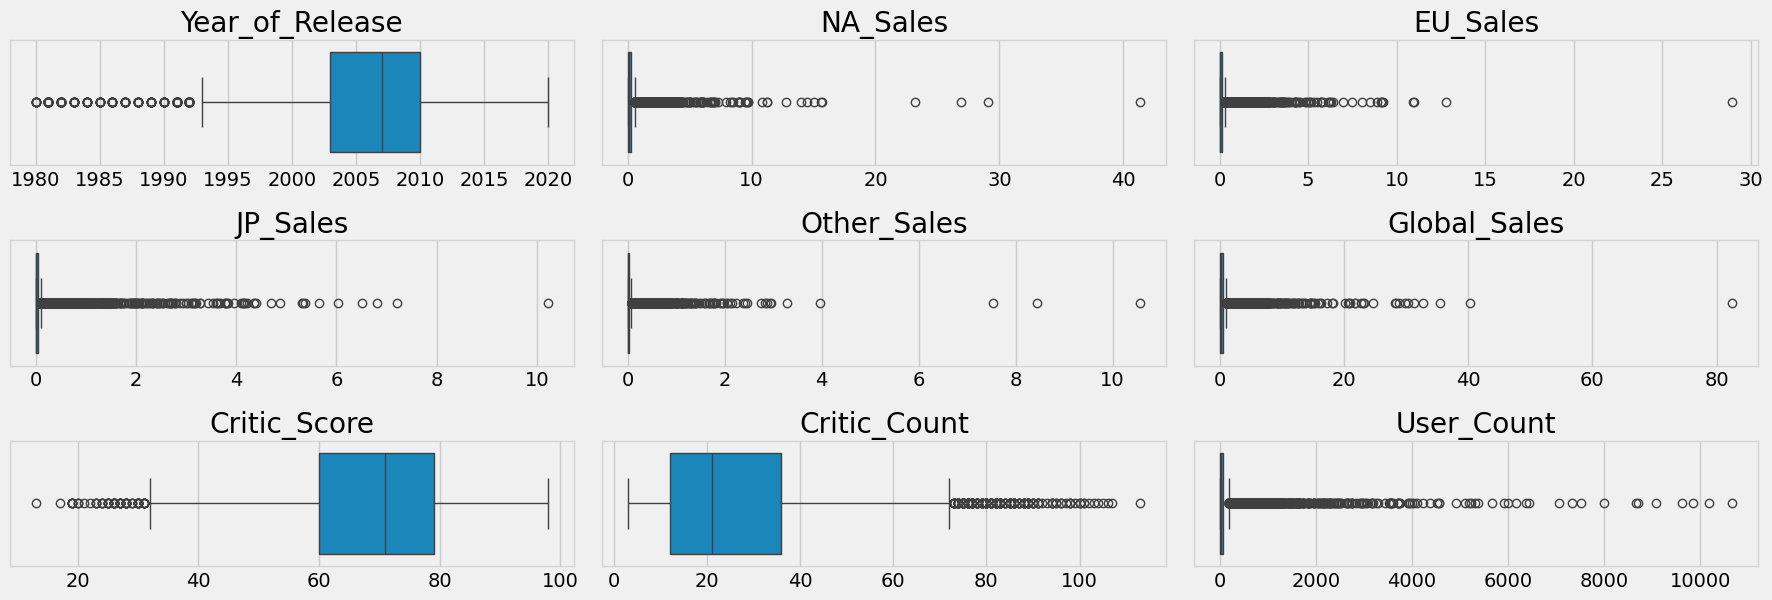

In [17]:
# Visualizing numerical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(18, 10))
n_rows = 5
n_cols = 3
for i, col in enumerate(num_cols, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col], ax=ax)
    plt.title(col)
    plt.xlabel("")
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linewidth(1)
plt.tight_layout() 
plt.show()

## 4. Content-Based Filtering
This section implements a recommendation system using TF-IDF and cosine similarity.

In [18]:
# Create the combined metadata column
df['game'] = (
    df['Name'] + ', ' +
    df['Platform'] + ', ' +
    df['Year_of_Release'].astype(str) + ', ' +
    df['Genre'] + ', ' +
    df['Publisher'] + ', ' +
    df['Rating']
)

df.dropna(subset=['game'], inplace=True)  # Drop rows where 'game' is NaN
df['game'] = df['game'].str.lower()  # Convert to lowercase for uniformity

In [19]:
# Sample and remove duplicates
samp = df.copy()
samp = samp.sample(10000)  # Sampling 10,000 rows # <--- simply comment this line to get full data
samp = samp.drop_duplicates(subset=['game']).reset_index(drop=True)
samp.shape

(10000, 17)

In [20]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(samp['game']).toarray()
# Compute Cosine Similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [21]:
def get_recommendations(title, cosine_sim=cosine_sim, num_recommend=5):
    # Create an index mapping using the 'game' column
    indices = pd.Series(samp.index, index=samp['Name']).drop_duplicates()

    # Find all games matching the given title
    matching_games = samp[samp['Name'] == title]
    
    if matching_games.empty:
        return f"'{title}' not found in the dataset. Please check the spelling or try another title."
    
    if len(matching_games) > 1:
        print(f"Multiple entries found for '{title}':")
        print(matching_games[['Name', 'Year_of_Release', 'Platform', 'Genre', 'Publisher']])
        print("\nUsing all matching entries for recommendations.")
    
    # Collect similarity scores for all matching entries
    recommendation_list = []
    for idx in matching_games.index:
        # Compute similarity scores
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Get the top recommendations for this index
        top_similar = sim_scores[1:num_recommend + 1]
        game_indices = [i[0] for i in top_similar]
        
        # Prepare recommendations for this index
        recommendations = samp.iloc[game_indices][['Name', 'Year_of_Release', 'Platform', 'Genre', 'Publisher']].copy()
        recommendations['Similarity_Score'] = [score for _, score in top_similar]
        recommendation_list.append(recommendations)
    
    # Combine recommendations for all matching entries and remove duplicates
    final_recommendations = (
        pd.concat(recommendation_list)
        .drop_duplicates(subset=['Name', 'Platform', 'Year_of_Release'])
        .sort_values(by='Similarity_Score', ascending=False)
        .reset_index(drop=True)
    )
    return final_recommendations.head(num_recommend)


In [22]:
samp.sort_values(by='Global_Sales', ascending=False).head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,game
6302,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,E,"super mario bros., nes, 1985, platform, ninten..."
3418,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,T,"pokemon red/pokemon blue, gb, 1996, role-playi..."
3337,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,NaN,NaN,NaN,NaN,NaN,E,"tetris, gb, 1989, puzzle, nintendo, e"
231,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E,"new super mario bros., ds, 2006, platform, nin..."
2307,Wii Play,Wii,2006,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E,"wii play, wii, 2006, misc, nintendo, e"


In [23]:
random_names = samp.sample(n=3, random_state=42)['Name']
print(random_names)

6252                  Fighting Force 2
4684              Snood 2: On Vacation
1731    LEGO Batman 2: DC Super Heroes
Name: Name, dtype: object


In [25]:
print(get_recommendations("Fighting Force 2"))

                       Name  Year_of_Release Platform     Genre  \
0            Fighting Force             1997       PS  Fighting   
1               Urban Chaos             1999       PS    Action   
2         Fighting Force 64             1999      N64    Action   
3  Resident Evil 3: Nemesis             1999       PS    Action   
4   Commandos: Strike Force             2006      PS2   Shooter   

             Publisher  Similarity_Score  
0    Eidos Interactive          0.774318  
1    Eidos Interactive          0.517860  
2  Crave Entertainment          0.486308  
3    Eidos Interactive          0.465073  
4    Eidos Interactive          0.420665  


In [26]:
print(get_recommendations("Snood 2: On Vacation"))

Multiple entries found for 'Snood 2: On Vacation':
                      Name  Year_of_Release Platform   Genre  \
4053  Snood 2: On Vacation             2005       DS  Puzzle   
4684  Snood 2: On Vacation             2005      GBA  Puzzle   

                   Publisher  
4053  Zoo Digital Publishing  
4684  Zoo Digital Publishing  

Using all matching entries for recommendations.
                   Name  Year_of_Release Platform   Genre  \
0  Snood 2: On Vacation             2005      GBA  Puzzle   
1  Snood 2: On Vacation             2005       DS  Puzzle   
2       Puzzle Kingdoms             2009       DS  Puzzle   
3          Sudoku Mania             2006       DS  Puzzle   
4    Paperboy / Rampage             2005      GBA    Misc   

                Publisher  Similarity_Score  
0  Zoo Digital Publishing          0.954884  
1  Zoo Digital Publishing          0.954884  
2  Zoo Digital Publishing          0.513796  
3  Zoo Digital Publishing          0.444367  
4  Zoo Digital Pu

In [27]:
print(get_recommendations("LEGO Batman 2: DC Super Heroes"))

Multiple entries found for 'LEGO Batman 2: DC Super Heroes':
                                Name  Year_of_Release Platform   Genre  \
740   LEGO Batman 2: DC Super Heroes             2012      3DS  Action   
1731  LEGO Batman 2: DC Super Heroes             2013     WiiU  Action   
2031  LEGO Batman 2: DC Super Heroes             2012       DS  Action   
8714  LEGO Batman 2: DC Super Heroes             2012     X360  Action   

                                   Publisher  
740   Warner Bros. Interactive Entertainment  
1731  Warner Bros. Interactive Entertainment  
2031  Warner Bros. Interactive Entertainment  
8714  Warner Bros. Interactive Entertainment  

Using all matching entries for recommendations.
                             Name  Year_of_Release Platform   Genre  \
0  LEGO Batman 2: DC Super Heroes             2012       DS  Action   
1  LEGO Batman 2: DC Super Heroes             2012     X360  Action   
2  LEGO Batman 2: DC Super Heroes             2013     WiiU  Action   


## Conclusion

- depending on the case it's probably better to reccomend only a game that is on the same platform


This notebook provides a comprehensive analysis of the video game dataset, including data preprocessing, exploratory data analysis, and a recommendation system.